In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import networkx as nx
import scipy
import pickle
%matplotlib inline
%load_ext autoreload
%autoreload 2
import graph_learning_utils as gl

In [2]:
plt.rcParams['figure.figsize'] = [15, 10]
sns.set_style('whitegrid')
plt.rcParams['font.size'] = 20.0
plt.rcParams['xtick.labelsize'] = 20.0
plt.rcParams['ytick.labelsize'] = 20.0

In [3]:
import itertools

# Graph generator

In [4]:
n = 100
ground_truth = gl.generate_ground_truth_mat(n)

### noise model

If we have a gaussian with known mean and unknown variance then the conjugate prior for the variance is given by the inverse gamma (IG) distribution. 
https://people.eecs.berkeley.edu/~jordan/courses/260-spring10/lectures/lecture5.pdf

The posterior distribution of $\sigma^2$ given data $x_1, \dots, x_n$ is another inverse gamma. 

Of course, it's not clear that this fact translates to our weird matrix setting, but that's fine for now. 

In [5]:
sigma_distr = scipy.stats.invgamma(a=1)

single_sigma = sigma_distr.rvs()
sigmas_arr = sigma_distr.rvs(n)

In [6]:
single_stdev = np.sqrt(single_sigma)

In [7]:
single_stdev

1.306873021998143

In [8]:
single_sigma

1.7079170956265588

In [9]:
mat_noise_product = np.ones(shape=(n, 1)) @ np.expand_dims(sigmas_arr, axis=0)
noise_vars = mat_noise_product + mat_noise_product.T

In [10]:
stdevs_matrix = np.sqrt(noise_vars)

In [11]:
X_mat = np.zeros_like(ground_truth)
A_mat = np.zeros_like(ground_truth)
for i in range(n): 
    for j in range(i + 1): 
        noise_var = np.random.normal(loc=0, scale=stdevs_matrix[i, j])
        A_noise = np.random.normal(loc=0, scale=single_stdev)
        X_mat[i, j] = ground_truth[i, j] + noise_var
        X_mat[j, i] = X_mat[i, j]
        A_mat[i, j] = ground_truth[i, j] + A_noise
        A_mat[j, i] = A_mat[i, j]

## all together

In [12]:
def generate_data(n, m, inv_gamma_param = 1): 
    ground_truth = gl.generate_ground_truth_mat(n)
    X_mats = [np.zeros_like(ground_truth) for _ in range(m)]
    A_mat = np.zeros_like(ground_truth)

    sigma_distr = scipy.stats.invgamma(a=inv_gamma_param)

    single_sigma = sigma_distr.rvs()
    single_stdev = np.sqrt(single_sigma)
    sigmas_arr = sigma_distr.rvs(n)
    mat_noise_product = np.ones(shape=(n, 1)) @ np.expand_dims(sigmas_arr, axis=0)
    noise_vars = mat_noise_product + mat_noise_product.T
    stdevs_matrix = np.sqrt(noise_vars)
    
    for i in range(n): 
        for j in range(i + 1): 
            A_noise = np.random.normal(loc=0, scale=single_stdev)
            A_mat[i, j] = ground_truth[i, j] + A_noise
            A_mat[j, i] = A_mat[i, j]

            for s in range(m): 
                noise_var = np.random.normal(loc=0, scale=stdevs_matrix[i, j])
                X_mats[s][i, j] = ground_truth[i, j] + noise_var
                X_mats[s][j, i] = X_mats[s][i, j]
    return ground_truth, A_mat, X_mats, single_stdev, np.sqrt(sigmas_arr)

In [13]:
def generate_X_data(n, m, ground_truth_matrix, inv_gamma_param=1): 
    X_mats = [np.zeros_like(ground_truth_matrix) for _ in range(m)]
    sigma_distr = scipy.stats.invgamma(a=inv_gamma_param)

    sigmas_arr = sigma_distr.rvs(n)
    mat_noise_product = np.ones(shape=(n, 1)) @ np.expand_dims(sigmas_arr, axis=0)
    noise_vars = mat_noise_product + mat_noise_product.T
    stdevs_matrix = np.sqrt(noise_vars)

    for i in range(n): 
        for j in range(i + 1): 
            for s in range(m): 
                noise_var = np.random.normal(loc=0, scale=stdevs_matrix[i, j])
                X_mats[s][i, j] = ground_truth[i, j] + noise_var
                X_mats[s][j, i] = X_mats[s][i, j]
    return X_mats, np.sqrt(sigmas_arr)

### recovering the MLE estimates as a system of equations

We have a linear system in $\sigma^2, \sigma_1^2, \dots, \sigma_n^2$. 

In [8]:
def generate_U(n):
    # Create a matrix of zeros with (n + 1 choose 2) rows and n+1 columns
    U = np.zeros((int((n+1)*n/2), n + 1), dtype=int)
    
    # Set the first column to all ones
    U[:, 0] = 1
    iterable_obj = enumerate(itertools.combinations_with_replacement(range(n), 2))
    
    for i, (j, k) in iterable_obj: 
        if j == k: 
            U[i, j + 1] = 2
        else: 
            U[i, j+1], U[i, k+1] = 1, 1
    return U

In [49]:
def solve_for_sigmas(X_mat, A_mat): 
    X_vals = X_mat[np.triu_indices(n)]
    A_vals = A_mat[np.triu_indices(n)]
    diff_vals = np.square(X_vals - A_vals)

    # set up linear system 
    T_mat = generate_U(n)
    x, rnorm = scipy.optimize.nnls(T_mat, diff_vals, maxiter= 10 * T_mat.shape[1])
    print(f'residual norm {rnorm}')
    return np.sqrt(x), rnorm 

In [53]:
X_vals = X_mat[np.triu_indices(n)]
A_vals = A_mat[np.triu_indices(n)]
diff_vals = np.square(X_vals - A_vals)

In [76]:
T_mat = generate_U(n)

In [77]:
np.allclose(np.sum(T_mat, axis=1), 3)

True

In [82]:
diff_vals.shape

(5050,)

In [83]:
T_mat.shape

(5050, 101)

In [86]:
x, residuals, rank, s = np.linalg.lstsq(T_mat, diff_vals);

/tmp/ipykernel_822447/3615982512.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x, residuals, rank, s = np.linalg.lstsq(T_mat, diff_vals);


In [87]:
rank

101

In [88]:
residuals

array([11222283.2266226])

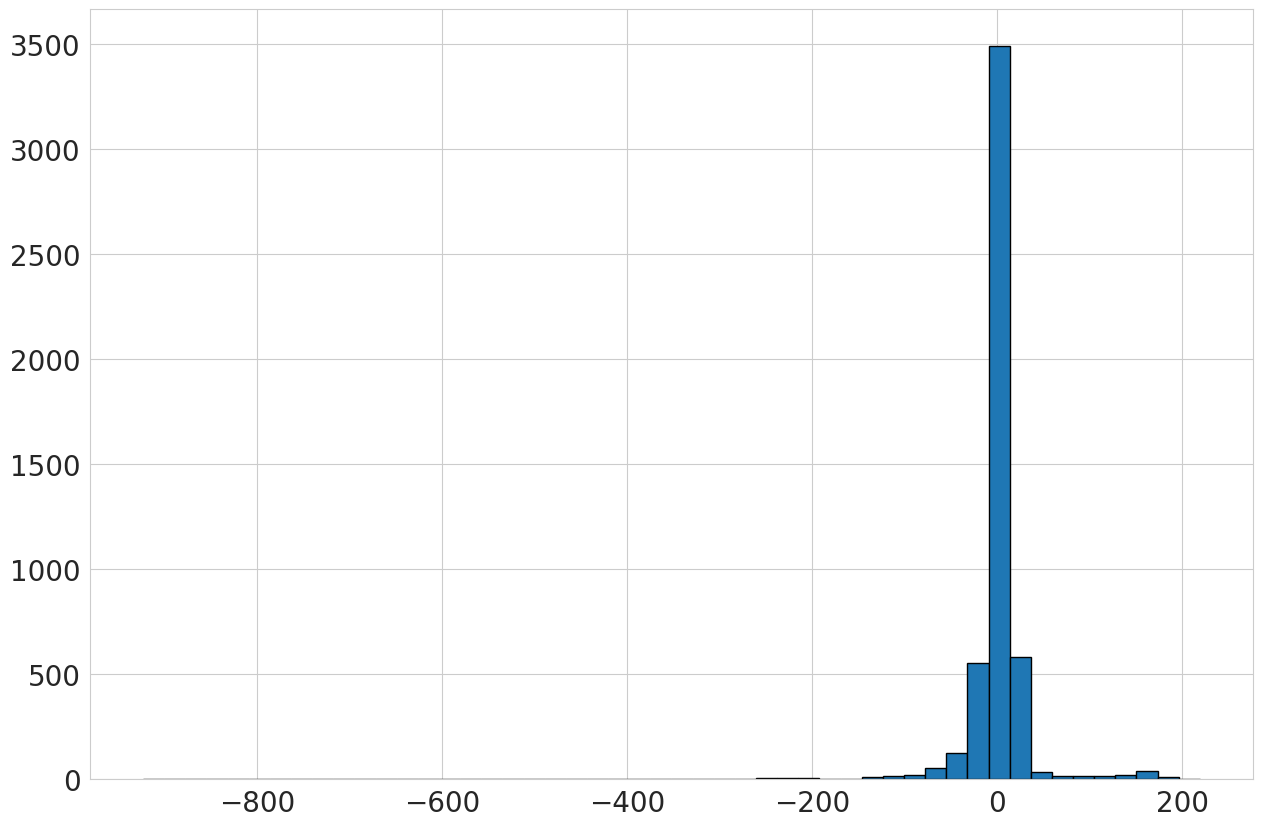

In [91]:
plt.hist(T_mat @ x - diff_vals, bins = 50, ec='k');

Hmm. What would we expect here? 

Note that the matrix is tall and narrow, with order (n^2) rows but only (n) columns. 

This implies that the system is overdetermined heavily. We shouldn't expect perfect solutions. 

### sigma inferences

In [94]:
x

array([-4.76154571e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  2.38077285e+13,  2.38077285e+13,  2.38077285e+13,
        2.38077285e+13,  

In [93]:
np.sqrt(x)

/tmp/ipykernel_822447/393099422.py:1: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(x)


array([             nan, 4879316.40168404, 4879316.40168335,
       4879316.40168379, 4879316.40168317, 4879316.4016839 ,
       4879316.4016834 , 4879316.40168345, 4879316.40168361,
       4879316.40168384, 4879316.40168328, 4879316.4016836 ,
       4879316.40168375, 4879316.40170088, 4879316.40168307,
       4879316.40168303, 4879316.40168428, 4879316.40168387,
       4879316.40168322, 4879316.40168292, 4879316.40168363,
       4879316.40168363, 4879316.40168295, 4879316.4016834 ,
       4879316.40168361, 4879316.40168324, 4879316.40168328,
       4879316.40168392, 4879316.40168456, 4879316.40168682,
       4879316.40168316, 4879316.40168328, 4879316.40168326,
       4879316.4016834 , 4879316.40168414, 4879316.40168417,
       4879316.40168364, 4879316.40168311, 4879316.40168664,
       4879316.4016833 , 4879316.40168333, 4879316.40168494,
       4879316.40168333, 4879316.40168483, 4879316.4016835 ,
       4879316.40168333, 4879316.40168414, 4879316.40168338,
       4879316.40168358,

### nonnegative constraint

In [100]:
true_sigmas = np.append(single_stdev, np.sqrt(sigmas_arr))

In [105]:
x, rnorm = scipy.optimize.nnls(T_mat, diff_vals, maxiter= 10 * T_mat.shape[1])

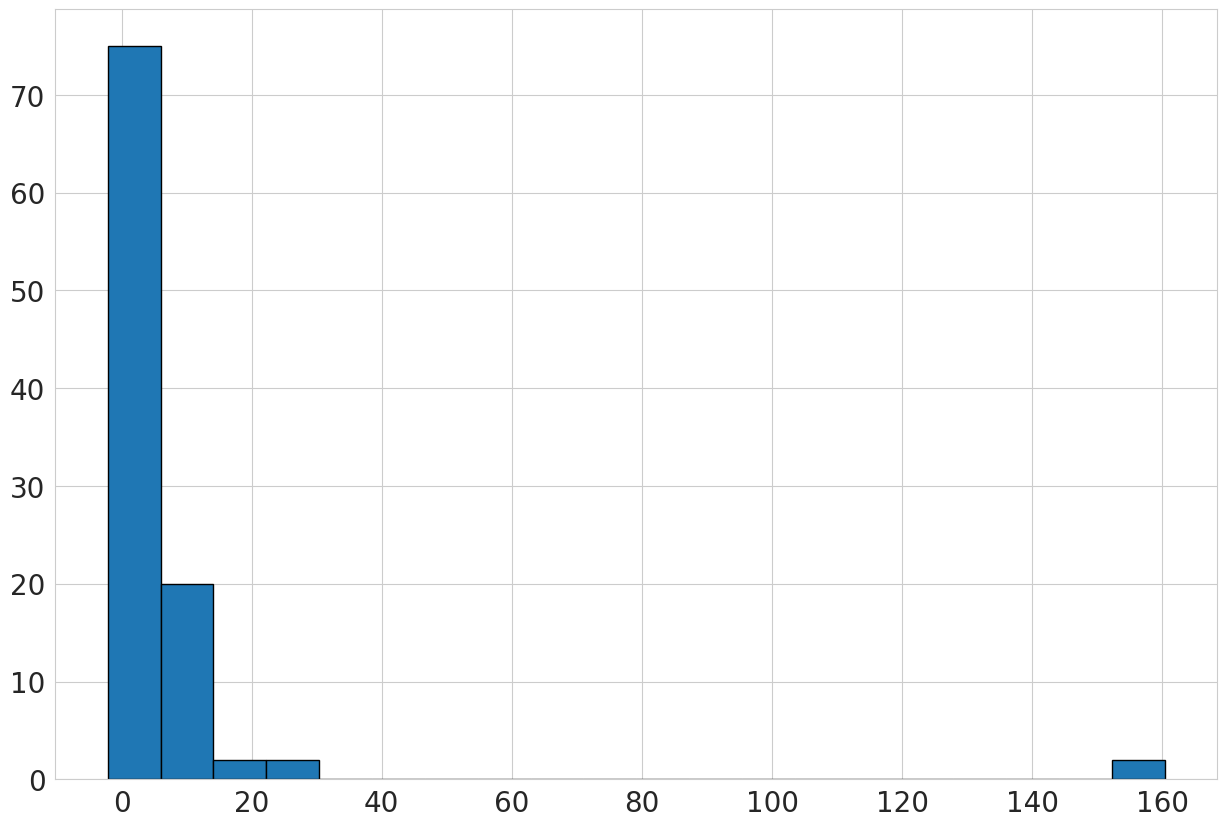

In [106]:
plt.hist(x - true_sigmas, bins=20, ec='k');

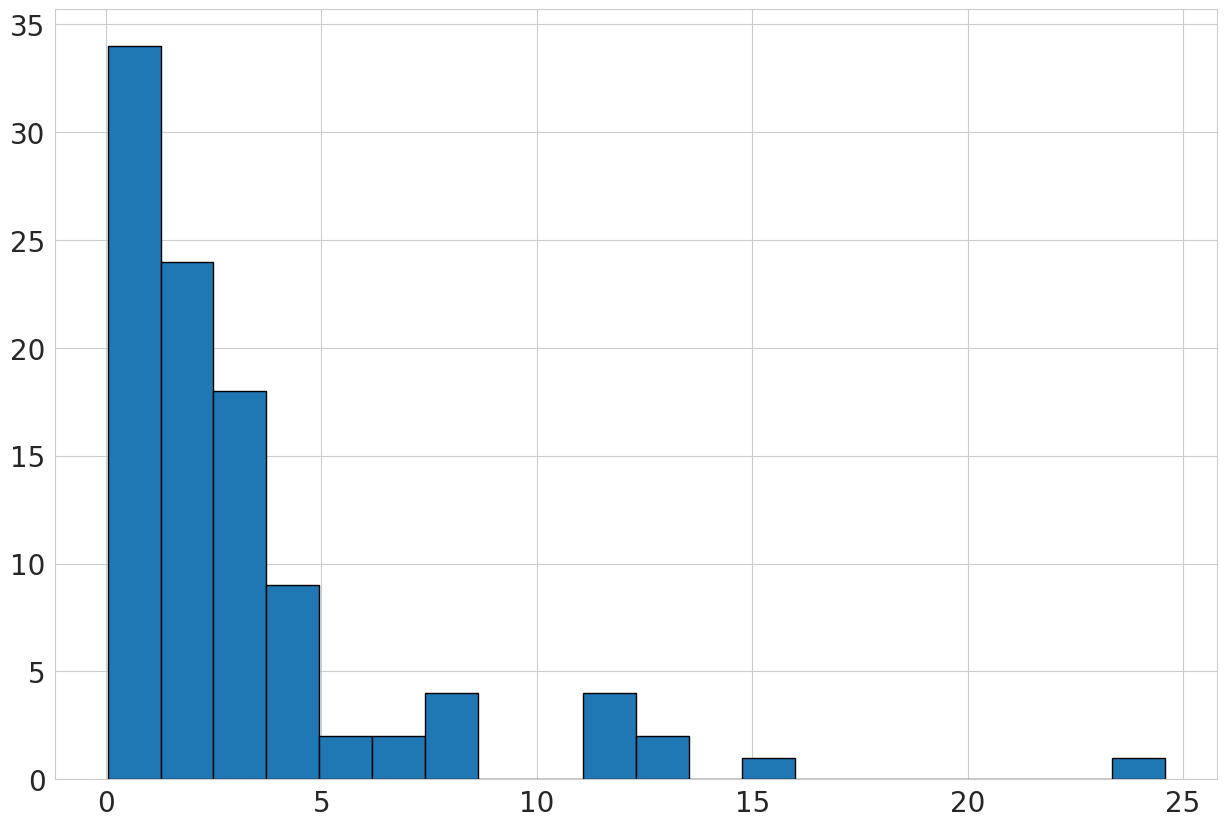

In [111]:
plt.hist(np.divide(np.abs(x - true_sigmas), true_sigmas), bins=20, ec='k');

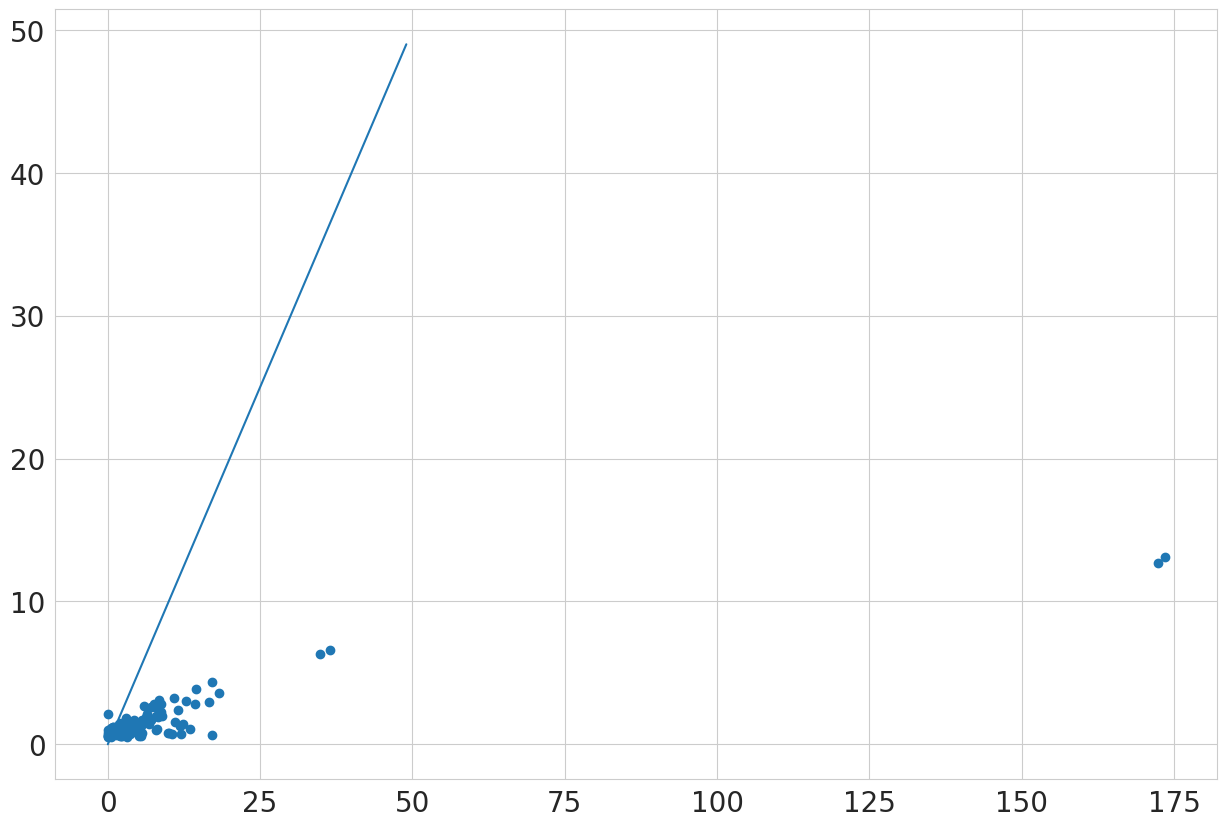

In [109]:
plt.scatter(x, true_sigmas)
plt.plot(np.arange(50), np.arange(50))

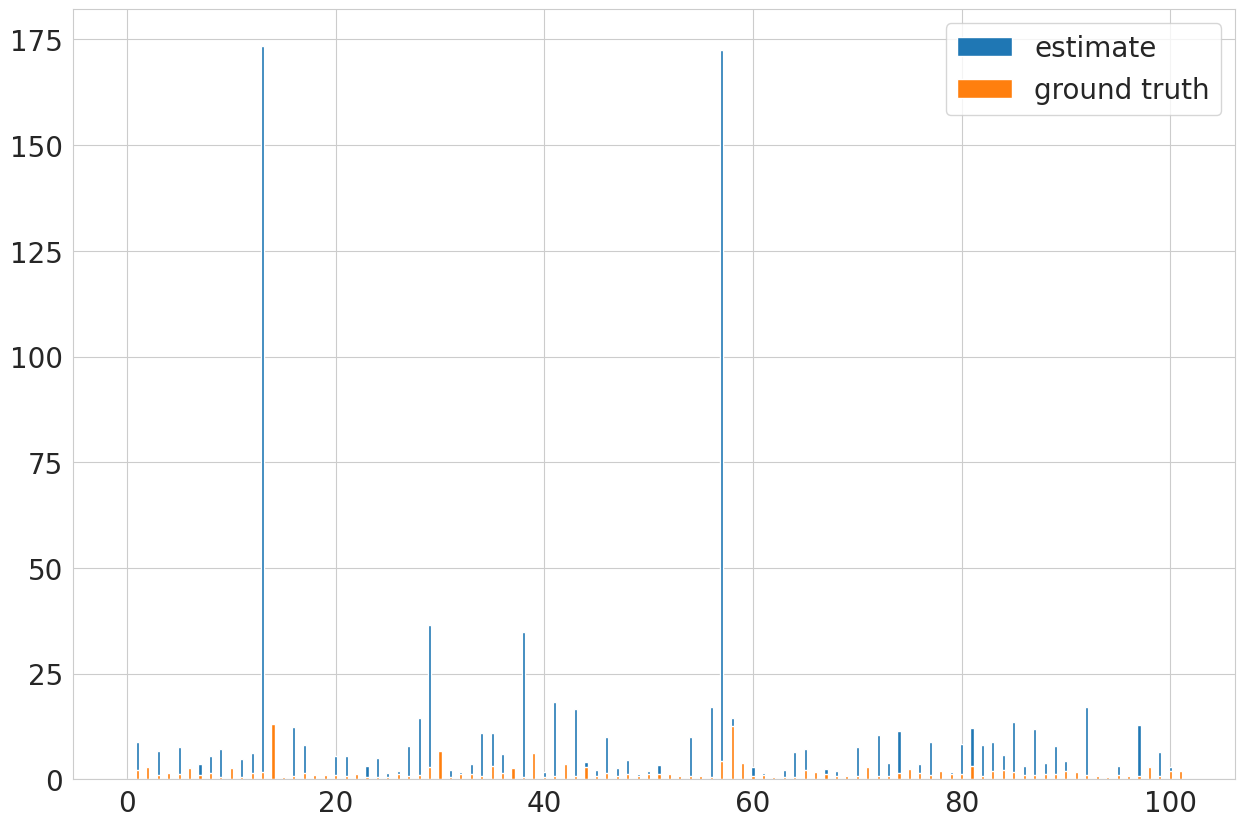

In [104]:
plt.bar(np.arange(n+1), x, width=0.3, label='estimate')
plt.bar(np.arange(n+1) + 1, true_sigmas, width=0.3, label='ground truth')
plt.legend();

# more performance analyses

* How does more data help us resolve these errors in the case where we only have a single A^s? In particular, can we average in the MLE if each X_mat experiences noise in the same way? 

A: It's not clear that more data helps. 

* What if we replace A^s with the ground truth matrix? Does this make single shot estimation better? 

A: Residuals go down, but the actual errors wrt ground truth sigma goes up. Not sure why... 

* In theory, what should we expect our errors to look like for sigma estimation? What if we use inverse gamma? 

### average of many data points 

In [10]:
n = 100 
m_range = [5, 10, 20]


In [11]:
errs_dict = {}

for m in m_range: 
    ground_truth, A_mat, X_mats, single_stdev, stdevs_arr = generate_data(n, m)
    X_mat_average = np.mean(X_mats, axis=0)
    print(X_mat_average.shape)
    sigmas_est = solve_for_sigmas(X_mat_average, A_mat)
    ground_truth_sigmas = np.append(single_stdev, stdevs_arr)
    errs_normalized = np.divide(np.abs(sigmas_est - ground_truth_sigmas), ground_truth_sigmas)
    errs_dict[m] = errs_normalized

(100, 100)
residual norm 538.6457019328427
(100, 100)
residual norm 254.58885339651536
(100, 100)
residual norm 645.476181230729


In [12]:
[np.mean(errs_dict[m]) for m in m_range]

[0.49332059362575126, 0.5477528955798923, 0.7020936313990822]

Okay, let's stick to a single A mat and then many sample mats. 

### getting performance wrt fixed validation

In [17]:
np.linspace(5, 100, 20)

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [20]:
m_range = np.linspace(5, 100, 20)

In [21]:
m_range

array([  5.,  10.,  15.,  20.,  25.,  30.,  35.,  40.,  45.,  50.,  55.,
        60.,  65.,  70.,  75.,  80.,  85.,  90.,  95., 100.])

In [22]:
errs_dict = {}

for m in m_range: 
    m = int(m)
    # ground_truth, A_mat, X_mats, single_stdev, stdevs_arr = generate_data(n, m)
    X_mats, stdevs_arr = generate_X_data(n, m, ground_truth)
    X_mat_average = np.mean(X_mats, axis=0)
    print(f'{m} samples')
    sigmas_est = solve_for_sigmas(X_mat_average, A_mat)
    ground_truth_sigmas = np.append(single_stdev, stdevs_arr)
    errs_normalized = np.divide(np.abs(sigmas_est - ground_truth_sigmas), ground_truth_sigmas)
    errs_dict[m] = errs_normalized

5 samples
residual norm 1403.2301402708817
10 samples
residual norm 713.527001987116
15 samples
residual norm 1042.3994475473257
20 samples
residual norm 705.8690235403702
25 samples
residual norm 636.6737434038284
30 samples
residual norm 594.9586298547355
35 samples
residual norm 593.225858432751
40 samples
residual norm 589.4039331307472
45 samples
residual norm 614.9264436244289
50 samples
residual norm 582.0370774664659
55 samples
residual norm 595.5943237110919
60 samples
residual norm 572.773627274424
65 samples
residual norm 607.0021910552165
70 samples
residual norm 578.1729457555771
75 samples
residual norm 598.6302967773146
80 samples
residual norm 583.4560329464242
85 samples
residual norm 574.4304696668819
90 samples
residual norm 596.6487340236322
95 samples
residual norm 674.3324813281976
100 samples
residual norm 578.8798739679208


In [23]:
[np.mean(errs_dict[m]) for m in m_range]

[0.7274429211497354,
 0.4887567353229903,
 0.7357659566496944,
 0.5955487018560077,
 0.6075126144550088,
 0.6541995273108461,
 0.5518052693946334,
 0.5219196223059482,
 0.8159618190154403,
 0.7459418170912887,
 0.5419593655176244,
 0.4833844655913224,
 0.5570881219468888,
 0.7361373697054577,
 0.7593504597729468,
 0.5049318426924085,
 0.7747882294097396,
 0.6693425174295959,
 0.5684115928986833,
 0.6231526617449904]

### replace A^s with ground truth

In [24]:
errs_dict_with_ground_truth = {}

for m in m_range: 
    m = int(m)
    # ground_truth, A_mat, X_mats, single_stdev, stdevs_arr = generate_data(n, m)
    X_mats, stdevs_arr = generate_X_data(n, m, ground_truth)
    X_mat_average = np.mean(X_mats, axis=0)
    print(f'{m} samples')
    sigmas_est = solve_for_sigmas(X_mat_average, ground_truth)
    ground_truth_sigmas = np.append(single_stdev, stdevs_arr)
    errs_normalized = np.divide(np.abs(sigmas_est - ground_truth_sigmas), ground_truth_sigmas)
    errs_dict_with_ground_truth[m] = errs_normalized

5 samples
residual norm 314.2279035774499
10 samples
residual norm 1048.595137570383
15 samples
residual norm 160.3868741209417
20 samples
residual norm 194.47592337111783
25 samples
residual norm 80.7726506386622
30 samples
residual norm 56.42470409863658
35 samples
residual norm 41.671674985337646
40 samples
residual norm 14051.85160562468
45 samples
residual norm 96.64091573288758
50 samples
residual norm 127.22723676099972
55 samples
residual norm 627.7518551726928
60 samples
residual norm 38.07806818210009
65 samples
residual norm 44.347005795023726
70 samples
residual norm 40.89413934810213
75 samples
residual norm 15.234533091131487
80 samples
residual norm 10.056894654082985
85 samples
residual norm 31.332570863618102
90 samples
residual norm 16.91662649603272
95 samples
residual norm 316.08837683318893
100 samples
residual norm 40.72462593278175


Aha! So the residuals definitely go down. What about errors? 

In [25]:
[np.mean(errs_dict[m]) for m in m_range]

[0.7274429211497354,
 0.4887567353229903,
 0.7357659566496944,
 0.5955487018560077,
 0.6075126144550088,
 0.6541995273108461,
 0.5518052693946334,
 0.5219196223059482,
 0.8159618190154403,
 0.7459418170912887,
 0.5419593655176244,
 0.4833844655913224,
 0.5570881219468888,
 0.7361373697054577,
 0.7593504597729468,
 0.5049318426924085,
 0.7747882294097396,
 0.6693425174295959,
 0.5684115928986833,
 0.6231526617449904]

In [26]:
[np.mean(errs_dict_with_ground_truth[m]) for m in m_range]

[0.6081008646970794,
 0.7955850302286208,
 0.7873435949537173,
 0.8262361157546808,
 0.8335743894452763,
 0.8275348625529213,
 0.8480972398646371,
 1.2862315646190523,
 0.8871717690810997,
 0.8800954144014924,
 0.8382141222314672,
 0.8932335684027813,
 0.8881878987908569,
 0.8919147764463932,
 0.8923848976647747,
 0.8991611434998922,
 0.9082422980028368,
 0.9043737204418564,
 0.87229874701678,
 0.9142044192805621]

What? This doesn't make sense...

### make plots

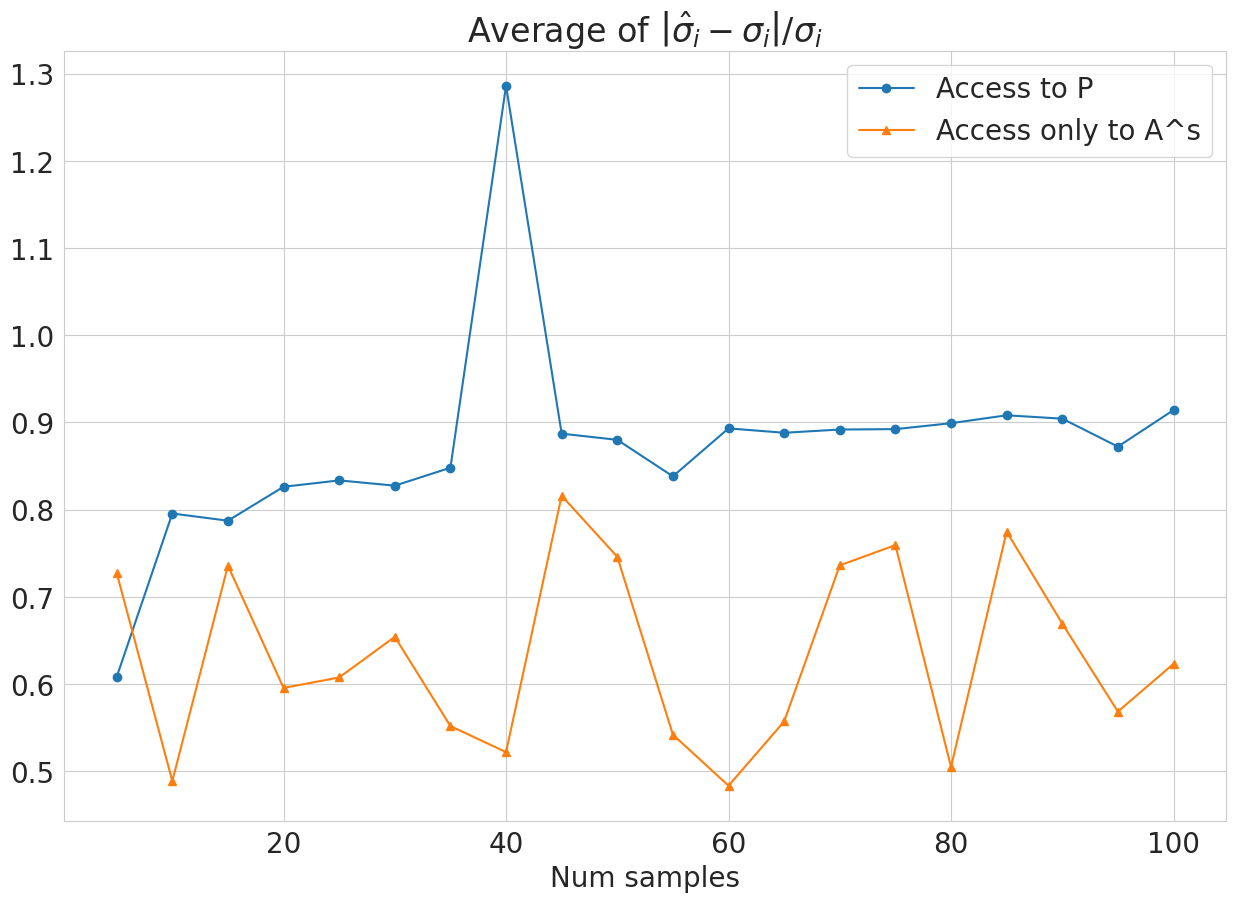

In [46]:
plt.plot(m_range, [np.mean(errs_dict_with_ground_truth[m]) for m in m_range], marker='o', label='Access to P')
plt.plot(m_range, [np.mean(errs_dict[m]) for m in m_range], marker='^', label='Access only to A^s')
plt.xlabel('Num samples')
plt.title(r'Average of $ \left\vert \hat \sigma_i - \sigma_i \right\vert / \sigma_i $'); 
plt.legend()

### rerun without division or normalization, only accessing A^s

In [50]:
errs_dict_with_ground_truth = {}
resid_norms = {}

for m in m_range: 
    m = int(m)
    # ground_truth, A_mat, X_mats, single_stdev, stdevs_arr = generate_data(n, m)
    X_mats, stdevs_arr = generate_X_data(n, m, ground_truth)
    X_mat_average = np.mean(X_mats, axis=0)
    print(f'{m} samples')
    sigmas_est, resid_norm = solve_for_sigmas(X_mat_average, ground_truth)
    ground_truth_sigmas = np.append(single_stdev, stdevs_arr)
    errs_list = np.abs(sigmas_est - ground_truth_sigmas)
    errs_dict_with_ground_truth[m] = errs_list
    resid_norms[m] = resid_norm

5 samples
residual norm 250.21216919396716
10 samples
residual norm 117.05918718631943
15 samples
residual norm 114.47240083125514
20 samples
residual norm 437.25764706106975
25 samples
residual norm 287.23180727875774
30 samples
residual norm 47.6223547364109
35 samples
residual norm 72.44864444933059
40 samples
residual norm 61.42453593125838
45 samples
residual norm 48.35455205204838
50 samples
residual norm 28.115318002128504
55 samples
residual norm 30.205319820648405
60 samples
residual norm 20.449507709984637
65 samples
residual norm 131.02763645507795
70 samples
residual norm 28.602884264827047
75 samples
residual norm 16.7201840878156
80 samples
residual norm 147.9461388563931
85 samples
residual norm 33.827147040344656
90 samples
residual norm 38.895324099124636
95 samples
residual norm 8.797094239705517
100 samples
residual norm 10.718415095082452


Text(0.5, 1.0, 'Performance of $ \\hat\\sigma $ recovery via linear system')

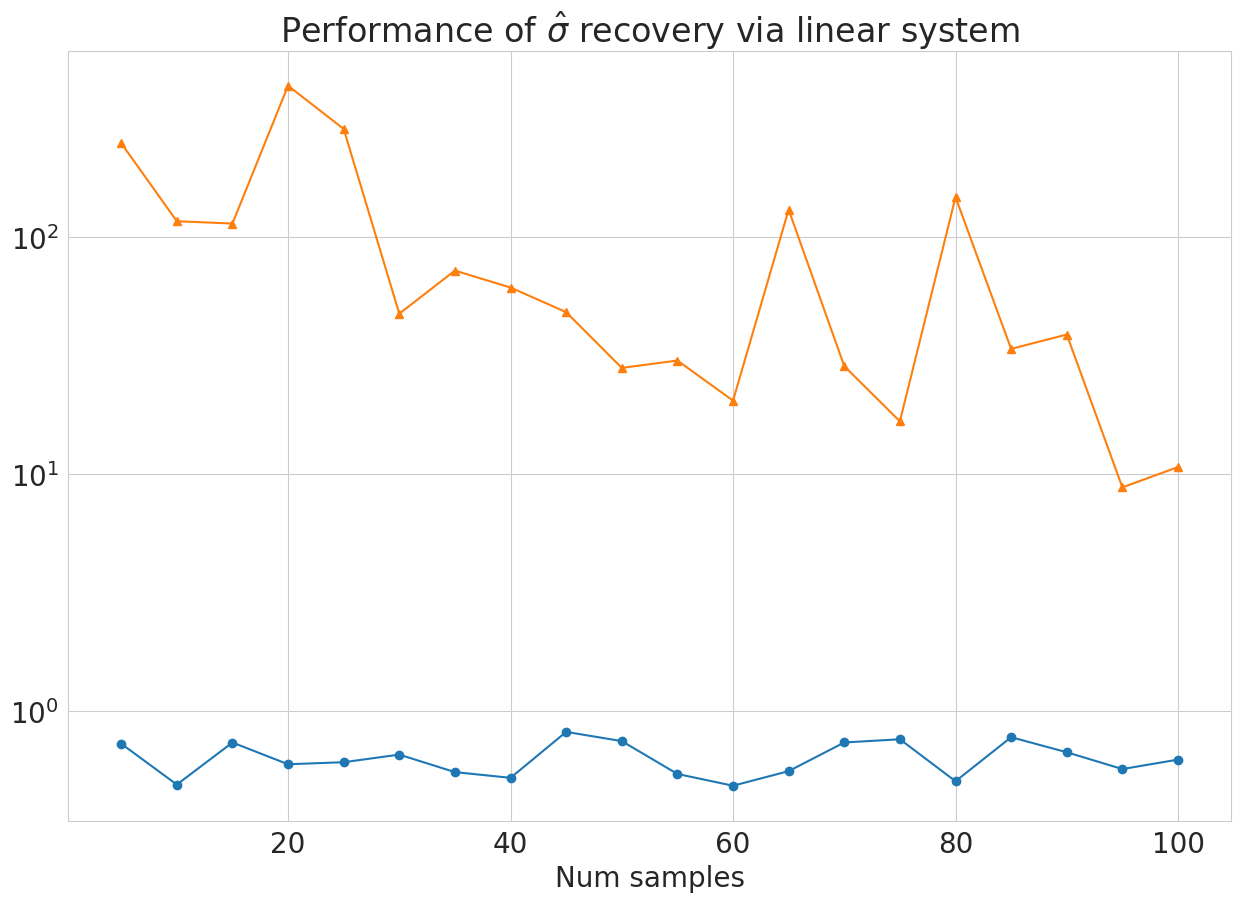

In [52]:
# plt.plot(m_range, [np.mean(errs_dict_with_ground_truth[m]) for m in m_range], marker='o', label='Access to P')
plt.plot(m_range, [np.mean(errs_dict[m]) for m in m_range], marker='o', 
    label=r'$ \left\vert \hat \sigma_i - \sigma_i \right\vert $')
plt.plot(m_range, [np.mean(resid_norms[m]) for m in m_range], marker='^', label='Residual norm')
plt.xlabel('Num samples')
plt.yscale('log')
plt.title(r'Performance of $ \hat\sigma $ recovery via linear system, InvGamma(1,1) priors, n=100')
# plt.title(r'Average of $ \left\vert \hat \sigma_i - \sigma_i \right\vert / \sigma_i $'); 
# plt.legend()

### theoretical analysis with inverse gamma



We are interested in estimating sigma for a mean zero Gaussian. 

Suppose we get $x_1, \dots, x_n \sim N(0, \sigma^2)$. Then if $\sigma^2 \sim IG(\alpha, \beta)$ then we can explicitly write out the sigma posterior distribution as: 

$$\sigma^2 | x_1, \dots, x_n \sim IG(\alpha + \frac n 2, \frac 1 2 \sum_i (x_i - 0))$$

In [156]:
# scipy gives inverse gamma with \beta = 1
# a is the alpha parameter 

invgamma_dist = scipy.stats.invgamma(a=1)
sigma_sq = invgamma_dist.rvs()

In [157]:
n_samples = 1000
x_data = np.random.normal(loc=0, scale=np.sqrt(sigma_sq), size=n_samples)

In [160]:
alpha_prior = 1
alpha_post = alpha_prior + n_samples / 2.0
beta_prior = 1
beta_post = beta_prior + 0.5 * np.sum(x_data)

# Joint MLE solve using EM

Steps are: 

* Initialize random guess for the sigma and sigma_1, ..., sigma_n 

(let's only do it for 1 sample for now)

* E step: compute the expected value of the log likelihood wrt the current parameters

* M step: maximize the expected value of the log likelihood wrt the current parameters

In [14]:
def init_guess(num_sigma): 
    sigma_guesses = np.random.uniform(low=0, high=1, size=num_sigma)
    return np.random.uniform(0, 1), sigma_guesses

In [33]:
def log_likelihood(P_ground, P_est, sigma_all): 
    '''
    sigma_all: the stdevs, length n (except for A^s, where it is length 1)
    (note that we will square these to get the variances)
    '''
    if len(sigma_all) == 1: 
        sigma_all = np.sqrt(0.5) * np.repeat(sigma_all[0], P_ground.shape[0])
    mat_noise_product = np.ones(shape=(n, 1)) @ np.expand_dims(np.square(sigma_all), axis=0)

    # each entry (i, j) is sigma_i^2 + sigma_j^2
    noise_vars_mat = mat_noise_product + mat_noise_product.T

    diff_mat_sq = np.square(P_ground - P_est)

    indices = np.triu_indices(P_ground.shape[0])

    numer = -0.5 * diff_mat_sq[indices].flatten()
    denom = noise_vars_mat[indices].flatten()
    ratio = np.sum(np.divide(numer, denom))
    
    first_term = -0.5 * np.sum(np.log(denom))
    return first_term + ratio


In [34]:
n = 20 
m = 1
ground_truth, A_mat, X_mats, single_stdev, stdevs_arr = generate_data(n, m)

In [39]:
single_stdev

0.3868122959257264

In [47]:
num_ticks = 400 
xrange = np.linspace(0.2, 0.5, num_ticks)
results = [log_likelihood(ground_truth, A_mat, [x]) for x in xrange]

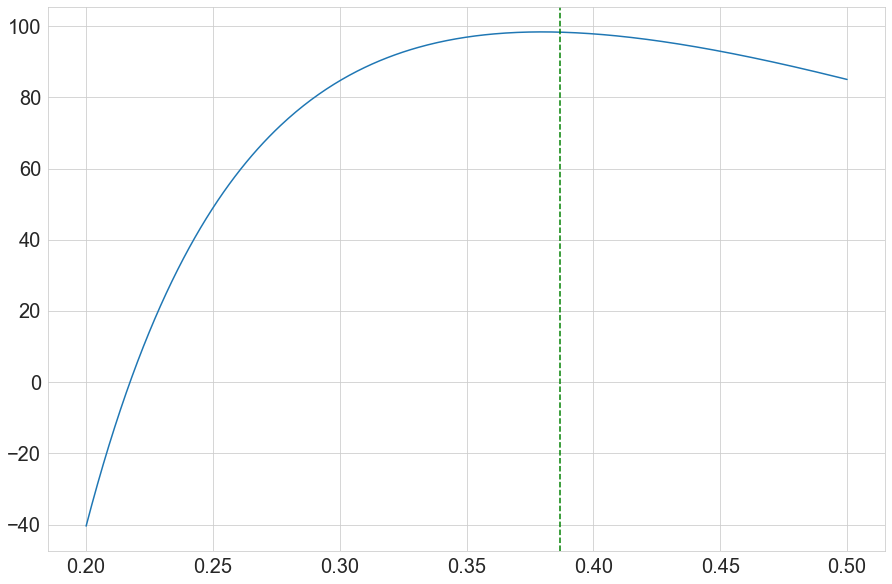

In [48]:
plt.plot(xrange, results)
plt.axvline(single_stdev, ls='--', color='green');

In [50]:
[log_likelihood(ground_truth, A_mat, [x]) for x in np.linspace(0.3, 0.4, 20)]

[84.64866042811963,
 86.74590316113529,
 88.6157176638709,
 90.27516738356587,
 91.73986215820369,
 93.02410096109489,
 94.14099870808332,
 95.1025991197086,
 95.91997535548055,
 96.6033199037766,
 97.16202501196632,
 97.60475477161107,
 97.93950982835693,
 98.17368556158519,
 98.31412447183557,
 98.36716342179221,
 98.3386762970056,
 98.23411258364189,
 98.05853230083997,
 97.81663767338861]

In [51]:
log_likelihood(ground_truth, A_mat, [single_stdev])

98.29617126076784